In [21]:
# Import necessary libraries
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
import requests
import json
import subprocess
import matplotlib.pyplot as plt

In [30]:
# Function to download stock data
def download_stock_data(ticker, start_date, end_date):
    """
    Downloads historical stock data using yfinance.
    """
    return yf.download(ticker, start=start_date, end=end_date)

# Function to prepare time-series data for LSTM
def prepare_data(data, time_steps):
    """
    Prepares data for LSTM input by creating sequences of time_steps.
    """
    x, y = [], []
    for i in range(len(data) - time_steps):
        x.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(x), np.array(y)

# Function to build the LSTM model
def build_lstm_model(input_shape):
    """
    Builds and compiles an LSTM model.
    """
    model = Sequential([
        LSTM(units=100, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(units=50),
        Dropout(0.2),
        Dense(units=1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Function to convert TensorFlow model to ONNX format
def convert_to_onnx(saved_model_dir, output_file="model.onnx"):
    """
    Converts a TensorFlow SavedModel to ONNX format.
    """
    command = f"python -m tf2onnx.convert --saved-model {saved_model_dir} --output {output_file}"
    subprocess.run(command, shell=True, check=True)

# Function to plot actual vs predicted prices
def plot_predictions(actual, predicted):
    """
    Plots the actual vs predicted stock prices.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(actual, color='blue', label='Actual Prices')
    plt.plot(predicted, color='red', label='Predicted Prices')
    plt.title('Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

# Function to make inference request to the model server
def make_request(model_server, input_data, token=None):
    """
    Sends a request to the model server and returns the response.
    """
    headers = {"Content-Type": "application/json"}
    if token:
        headers["Authorization"] = f"Bearer {token}"
    
    response = requests.post(model_server, headers=headers, data=json.dumps(input_data))
    if response.ok:
        return response.json()
    else:
        raise Exception(f"Request failed with status {response.status_code}: {response.text}")

# Function to predict stock prices for the next N days
def predict_next_days(model, scaler, input_sequence, days_to_predict=30):
    """
    Predicts stock prices for the next 'days_to_predict' days using the LSTM model.

    Parameters:
        model (tf.keras.Model): Trained LSTM model.
        scaler (MinMaxScaler): Scaler used for data normalization.
        input_sequence (ndarray): Initial input sequence of shape (1, time_steps, 1).
        days_to_predict (int): Number of days to predict.

    Returns:
        list: Predicted stock prices for the next 'days_to_predict' days.
    """
    predictions = []
    current_input = input_sequence.copy()

    for _ in range(days_to_predict):
        # Predict the next price
        predicted_scaled = model.predict(current_input)
        predicted_price = scaler.inverse_transform(predicted_scaled)

        # Save the prediction
        predictions.append(predicted_price[0][0])

        # Update the input sequence for the next prediction
        next_input = np.append(current_input[0, 1:], predicted_scaled).reshape(1, -1, 1)
        current_input = next_input

    return predictions

def predict_next_days_smooth(model, scaler, input_sequence, days_to_predict=30, alpha=0.8):
    """
    Predicts stock prices for the next 'days_to_predict' days using the LSTM model,
    with smoothing to reduce error propagation.

    Parameters:
        model (tf.keras.Model): Trained LSTM model.
        scaler (MinMaxScaler): Scaler used for data normalization.
        input_sequence (ndarray): Initial input sequence of shape (1, time_steps, 1).
        days_to_predict (int): Number of days to predict.
        alpha (float): Smoothing factor (0 < alpha <= 1).

    Returns:
        list: Smoothed predicted stock prices for the next 'days_to_predict' days.
    """
    predictions = []
    current_input = input_sequence.copy()

    for _ in range(days_to_predict):
        # Predict the next price
        predicted_scaled = model.predict(current_input)
        predicted_price = scaler.inverse_transform(predicted_scaled)[0][0]

        # Apply smoothing
        if predictions:
            predicted_price = alpha * predicted_price + (1 - alpha) * predictions[-1]

        # Save the smoothed prediction
        predictions.append(predicted_price)

        # Update the input sequence for the next prediction
        next_input = np.append(current_input[0, 1:], scaler.transform([[predicted_price]])).reshape(1, -1, 1)
        current_input = next_input

    return predictions



def evaluate_model(actual, predicted):
    """
    Evaluates the model using various regression metrics.
    """
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual, predicted)

    print("Model Evaluation Metrics:")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")

In [24]:
# Configuration
STOCK_SYMBOL = "TSLA"
START_DATE = "2022-01-01"
END_DATE = "2024-12-06"
TIME_STEPS = 120
EPOCHS =200
BATCH_SIZE = 32
SPLIT_RATIO = 0.8

# Download and process data
stock_data = download_stock_data(STOCK_SYMBOL, START_DATE, END_DATE)
closing_prices = stock_data['Close'].values.reshape(-1, 1)

# Scale the data to [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(closing_prices)

# Prepare the data for LSTM
x, y = prepare_data(scaled_prices, TIME_STEPS)

# Split data into training and testing sets
train_size = int(len(x) * SPLIT_RATIO)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build and train the model
model = build_lstm_model((x_train.shape[1], 1))
model.fit(x_train, y_train, validation_split=0.2, epochs=EPOCHS, batch_size=BATCH_SIZE)

# Save the trained model
model.save("lstm_model.keras")

# Save in TensorFlow SavedModel format
loaded_model = tf.keras.models.load_model("lstm_model.keras")
tf.saved_model.save(loaded_model, "models")

# Convert the model to ONNX format
convert_to_onnx("models")


[*********************100%***********************]  1 of 1 completed

Epoch 1/200



/opt/app-root/lib64/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 195ms/step - loss: 0.0834 - val_loss: 0.0013
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - loss: 0.0137 - val_loss: 0.0091
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - loss: 0.0072 - val_loss: 0.0028
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - loss: 0.0068 - val_loss: 0.0019
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - loss: 0.0060 - val_loss: 0.0023
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - loss: 0.0059 - val_loss: 0.0019
Epoch 7/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - loss: 0.0046 - val_loss: 0.0013
Epoch 8/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - loss: 0.0057 - val_loss: 0.0014
Epoch 9/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - loss: 0.0047 - val_loss: 0.0013
Epoch 10/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - loss: 0.0046 - val_loss: 0.0016
Epoch 11/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - loss: 0.0043 - val_loss: 0.0012
Epoch 12/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step

INFO:tensorflow:Assets written to: models/assets
2024-12-06 22:34:31.101563: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-06 22:34:31.106767: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-06 22:34:31.125743: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733524471.158209   52858 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733524471.168141   52858 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-06 22:34:31.198404: I tensorflow/core/platform/cpu_feature_guard.cc:210] This Tensor

In [27]:
# Ensure consistent lengths between actual and predicted
min_length = min(len(actual_prices), len(predicted_prices))
actual_prices = actual_prices[:min_length]
predicted_prices = predicted_prices[:min_length]

# Evaluate the model
evaluate_model(actual_prices, predicted_prices)


Model Evaluation Metrics:
Mean Absolute Error (MAE): 8.4776
Mean Squared Error (MSE): 148.8822
Root Mean Squared Error (RMSE): 12.2017
R² Score: 0.9341


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Predicted next day's closing price for TSLA: $358.70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/st

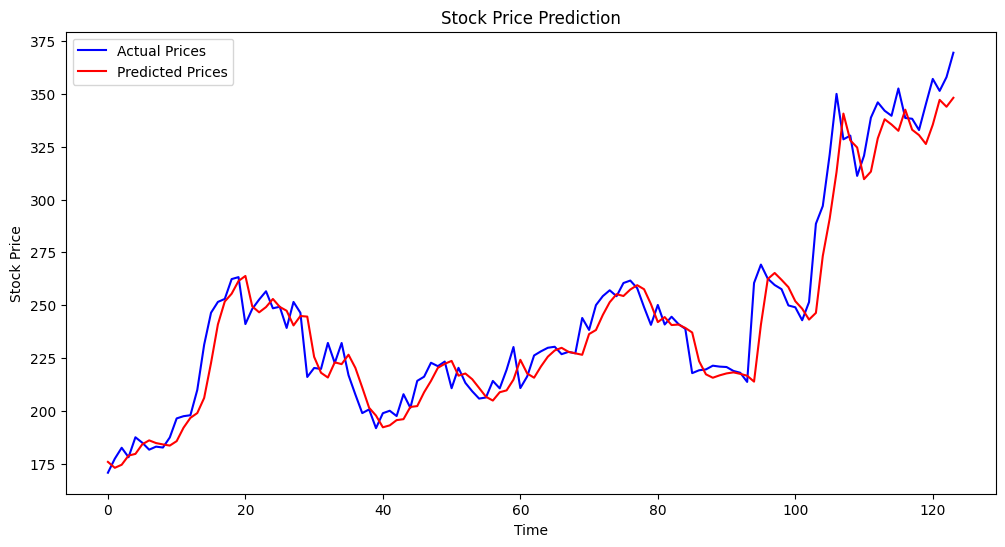

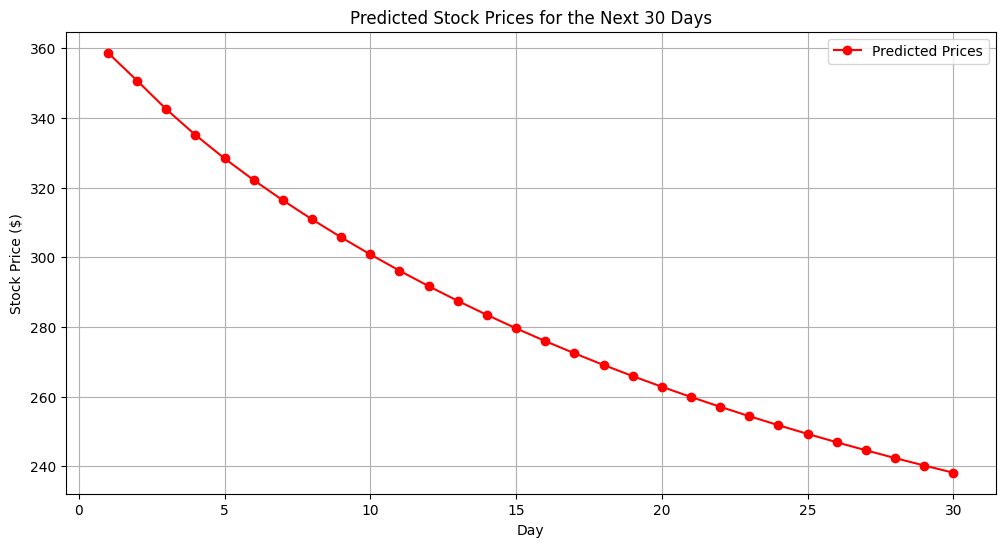

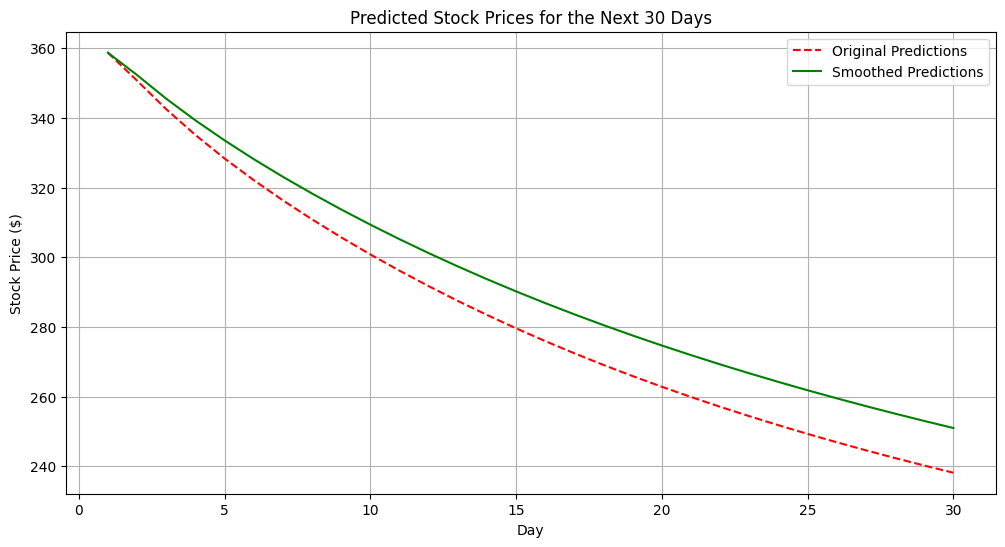

In [33]:
# Predict the next day's price
latest_input_sequence = scaled_prices[-TIME_STEPS:].reshape(1, TIME_STEPS, 1)
next_day_price = predict_next_days(model, scaler, latest_input_sequence, days_to_predict=1)[0]

print(f"Predicted next day's closing price for {STOCK_SYMBOL}: ${next_day_price:.2f}")

# Predict for the next 30 days
next_30_days_predictions = predict_next_days(model, scaler, latest_input_sequence, days_to_predict=30)

print(f"Predicted prices for the next 30 days:")
print(next_30_days_predictions)


next_30_days_smoothed = predict_next_days_smooth(model, scaler, latest_input_sequence, days_to_predict=30)

print(f"Predicted prices for the next 30 days:")
print(next_30_days_smoothed)

# Inverse transform the test set predictions
predictions = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predictions)
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the results
plot_predictions(actual_prices, predicted_prices)

# Plot the predictions for the next 30 days
plt.figure(figsize=(12, 6))
plt.plot(range(1, 31), next_30_days_predictions, marker='o', label="Predicted Prices", color="red")
plt.title("Predicted Stock Prices for the Next 30 Days")
plt.xlabel("Day")
plt.ylabel("Stock Price ($)")
plt.grid()
plt.legend()
plt.show()


# Plot original and smoothed predictions
plt.figure(figsize=(12, 6))
plt.plot(range(1, 31), next_30_days_predictions, label="Original Predictions", linestyle="--", color="red")
plt.plot(range(1, 31), next_30_days_smoothed, label="Smoothed Predictions", color="green")
plt.title("Predicted Stock Prices for the Next 30 Days")
plt.xlabel("Day")
plt.ylabel("Stock Price ($)")
plt.legend()
plt.grid()
plt.show()


In [46]:
# Define the input data, this is just mock data. 
input_data = {
    "inputs": [
        {
            "name": "inputs",
            "shape": [1, 120, 1],
            "datatype": "FP32",
            "data": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0,
                     1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0,
                     2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0,
                     3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0,
                     4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5.0,
                     4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5.0, 
                     0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0,
                     1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0,
                     2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0,
                     3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0,
                     4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5.0,
                     4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5.0]
        }
    ]
}

MODEL_SERVER = "https://stock-prediction-netsentinel.apps.cluster-96ht8.96ht8.sandbox1919.opentlc.com/v2/models/stock-prediction/infer"


In [48]:
# Infer without token

try:
    print("Making request without token...")
    response_no_token = make_request(MODEL_SERVER, input_data)
    print("Response without token:", response_no_token)
except Exception as e:
    print("Error without token:", e)

Making request without token...
Response without token: {'model_name': 'stock-prediction__isvc-c108a7e109', 'model_version': '1', 'outputs': [{'name': 'output_0', 'datatype': 'FP32', 'shape': [1, 1], 'data': [3.4790378]}]}


In [47]:
# Infer with token
TOKEN = "eyJhbGciOiJSUzI1NiIsImtpZCI6InZEenNhUlNfdkQ3dC15cWZLTWFzbnlPZU8xcDVQMk53QWROSUQ5ZzA3LXMifQ.eyJpc3MiOiJrdWJlcm5ldGVzL3NlcnZpY2VhY2NvdW50Iiwia3ViZXJuZXRlcy5pby9zZXJ2aWNlYWNjb3VudC9uYW1lc3BhY2UiOiJuZXRzZW50aW5lbCIsImt1YmVybmV0ZXMuaW8vc2VydmljZWFjY291bnQvc2VjcmV0Lm5hbWUiOiJkZWZhdWx0LW5hbWUtc3RvY2stcHJlZGljdGlvbi1zYSIsImt1YmVybmV0ZXMuaW8vc2VydmljZWFjY291bnQvc2VydmljZS1hY2NvdW50Lm5hbWUiOiJzdG9jay1wcmVkaWN0aW9uLXNhIiwia3ViZXJuZXRlcy5pby9zZXJ2aWNlYWNjb3VudC9zZXJ2aWNlLWFjY291bnQudWlkIjoiMDU0ODljODAtOTJlMi00OWVmLThiNTItZTk4YmFjYzU2OThkIiwic3ViIjoic3lzdGVtOnNlcnZpY2VhY2NvdW50Om5ldHNlbnRpbmVsOnN0b2NrLXByZWRpY3Rpb24tc2EifQ.UGDsmjpUH4tLm5ysY-DzFMGNDnVGPqMGbxGEsTbN3fBsDIflukI7h3yMn_crlGhcvww26D0Lfcs7dx9CW4HDT5YhqEHV4u4eoltrGCLajesNGvC8arNpq0o5EfHMcCT9tEKIi1FGYvTgSII4GKR_icC_EfpwV_bQoE8okLqloyraWBAdRR7Rm46wwrSOncS3jUZ-1r-oKvqsuV0C5zunmTRyUjtLr1EJ6dk47NlDLzbh954lF5IiBM2ow1lcByUskzaveiX-vlz9LS644u91khp-gBoCZbMFCkw4_UY7n8QPog_HZQX212oSuRhR_WFET6W3AzaGqRQKGmNu8TlV2gH0lhyC0Hzo_cRIm8wobbFG6oehs4quqG4vXSlZ9rVVg_GYIiR3W8Deuntlvv5cAGJ8I3U7xU8vHoTalir2NwLZovYmY0fJJ0TV0rZWc6G0Nlc_KgNSUIk_3F2qotjWNyBRV_UTDFCqIR40H7d9pY8zIAFpjFutlc15MIS2bDg66MRFEW7srFfwaIfpDD1yUXySI83z6crr5YEq9o1giCNnewq7C1Ie2tEFkqqexex4ABUu5frwT1jPuF6NL9Kh77WD2dzOnSBwnWLqldBc3JO6kA0XNNBws9WfJ2u1lHCPqA2WkO3xGBV03lRyhHIgAu7eA5KcREEgD4GzQDfw32U"

try:
    print("Making request with token...")
    response_with_token = make_request(MODEL_SERVER, input_data, token=TOKEN)
    print("Response with token:", response_with_token)
except Exception as e:
    print("Error with token:", e)


Making request with token...
Response with token: {'model_name': 'stock-prediction__isvc-c108a7e109', 'model_version': '1', 'outputs': [{'name': 'output_0', 'datatype': 'FP32', 'shape': [1, 1], 'data': [3.4790378]}]}
